<a href="https://colab.research.google.com/github/mjipark/MJ/blob/main/assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coding Assignment 3
- In this assignment, you have to train a simple matrix factorization model for the Small MovieLens dataset
- The goal of this assignment is to have an experience with what kind of information a recommendation system learns from data
- You have to submit a report and a code
  1. A Report in free format (submit in PDF)
    - Your setting about how you trained the model
    - Your answer and explanation of all problems (Problems 1-6)
    - Your submission would be evaluated mainly with the report
    - Please include the screen capture of the table and visualization in your report
  2. Code (submit in ipynb)
- You don't have to use GPU for this assignment. I recommend you not to use hardware accelerator on Colab



# 0. Import Library and Download data

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip
!wget https://raw.githubusercontent.com/jdasam/mas1004-2023/main/assignment_3_list_of_movie_titles.csv

--2025-11-25 08:53:20--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.96.204
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  4.37MB/s    in 0.2s    

2025-11-25 08:53:21 (4.37 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  
--2025-11-25 08:53:21--  https://raw.githubusercontent.com/jdasam/mas1004-2023/main/assignment_3_list_of_movie_titles.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.10

### Import libraries and functions

In [2]:
from tqdm.auto import tqdm
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import copy

class RatingSet:
  def __init__(self, csv_path='ml-latest-small/ratings.csv'):
    self.ratings = pd.read_csv(csv_path)

    # how many unique users exist in this dataset
    self.n_users = len(set(self.ratings['userId']))
    self.n_movies = len(set(self.ratings['movieId']))

    # list the every ids of included users
    self.user_ids = list(set(self.ratings['userId']))
    self.movie_ids = sorted(list(set(self.ratings['movieId'])))

    # we have to find in which idx the given movieId exists in this dataset's movie ID
    self.movie2idx = {id: idx for idx, id in enumerate(self.movie_ids)}
    self.user2idx = {id: idx for idx, id in enumerate(self.user_ids)}

  def __len__(self):
    return len(self.ratings) # number of ratings in the dataset

  def __getitem__(self, idx):
    idx_row = self.ratings.iloc[idx]

    user_id = self.user2idx[idx_row.userId]
    movie_id = self.movie2idx[idx_row.movieId]
    rating = idx_row.rating

    return user_id, movie_id, torch.tensor(rating, dtype=torch.float32)

class MatrixFactorizer(nn.Module):
  def __init__(self, n_user, n_movie, n_factor):
    super().__init__()

    self.user_embedding = nn.Embedding(n_user, n_factor)
    self.movie_embedding = nn.Embedding(n_movie, n_factor)

    self.user_embedding.weight.data /= n_factor ** 0.5
    self.movie_embedding.weight.data /= n_factor ** 0.5

    self.scale = 5.5

  def scaled_sigmoid(self, x):
    return 1/(1+torch.exp(-x/self.scale)) * self.scale

  def forward(self, user_id, movie_id):
    user_emb_vec = self.user_embedding(user_id)
    movie_emb_vec = self.movie_embedding(movie_id)

    dot_prod_result = torch.einsum('ij,ij->i', user_emb_vec, movie_emb_vec)
    return self.scaled_sigmoid(dot_prod_result)



class MatrixFactorizerWithBias(MatrixFactorizer):
  def __init__(self, n_user, n_movie, n_factor):
    super().__init__(n_user, n_movie, n_factor)
    self.user_bias = nn.Embedding(n_user, 1)
    self.movie_bias = nn.Embedding(n_movie, 1)
    self.user_bias.weight.data = torch.zeros(n_user, 1)
    self.movie_bias.weight.data = torch.zeros(n_movie, 1)


  def forward(self, user_id, movie_id):
    user_emb_vec = self.user_embedding(user_id)
    movie_emb_vec = self.movie_embedding(movie_id)

    dot_prod_result = torch.einsum('ij,ij->i', user_emb_vec, movie_emb_vec)
    dot_prod_result += self.user_bias(user_id)[:, 0] + self.movie_bias(movie_id)[:, 0]

    return self.scaled_sigmoid(dot_prod_result)

class Trainer:
  def __init__(self, model, train_loader, valid_loader, model_name='movielens', device='cpu'):
    self.model = model
    self.train_loader = train_loader
    self.valid_loader = valid_loader
    self.device = device
    self.model.to(self.device)
    self.criterion = nn.MSELoss()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
    self.acc_threshold = 0.5
    self.best_loss = torch.inf
    self.best_acc = 0.0
    self.train_losses = []
    self.valid_losses = []
    self.train_accs = []
    self.valid_accs = []
    self.model_name = model_name
    self.model_states = []

  def validation(self):
    self.model.eval() # change the model from train mode to evaluation mode
    # Some models work in different ways based on whtehter it is on training step
    # or on inference step

    # In validation step, you don't have to calculate the gradient
    # with torch.no_grad():

    current_loss = 0
    num_total_correct_pred = 0
    with torch.inference_mode(): # every torch computation under this indent
    # will be run without calculating the gradient or computation history
      for batch in self.valid_loader:
        user_ids, movie_ids, ratings = batch
        user_ids, movie_ids, ratings = user_ids.to(self.device), movie_ids.to(self.device), ratings.to(self.device)

        self.optimizer.zero_grad()
        outputs = self.model(user_ids, movie_ids)

        loss = self.criterion(outputs, ratings) # you have to feed log_probs

        num_acc_pred = (torch.abs(outputs - ratings) < self.acc_threshold).sum()

        num_total_correct_pred += num_acc_pred.item()
        # in validation stage, we don't care about single batch's loss
        # we want to see the result for total images of validation set

        current_loss += loss.item() * len(ratings)
        # instead of adding the mean loss, we add sum of loss
        # because the batch size can be different
    mean_loss = current_loss / len(self.valid_loader.dataset)
    mean_acc = num_total_correct_pred / len(self.valid_loader.dataset) # number of total datasample in the validation loader
    return mean_loss, mean_acc
    # return {'loss': mean_loss, 'acc': mean_acc}



  def train_by_number_of_epochs(self, num_epochs):
    epoch_bar = tqdm(range(num_epochs), desc="Epoch")
    for epoch in epoch_bar:
      self.model.train()
      for batch in tqdm(self.train_loader, leave=False, desc="Batch"):
        user_ids, movie_ids, ratings = batch
        user_ids, movie_ids, ratings = user_ids.to(self.device), movie_ids.to(self.device), ratings.to(self.device)
        self.optimizer.zero_grad()
        outputs = self.model(user_ids, movie_ids)

        loss = self.criterion(outputs, ratings) # you have to feed log_probs

        acc = (torch.abs(outputs - ratings) < self.acc_threshold).sum() / len(ratings)
        # for torch.nn.NLLLoss
        loss.backward()
        self.optimizer.step()

        self.train_losses.append(loss.item())
        self.train_accs.append(acc.item())
        # don't try self.train_losses.append(loss)
        # because loss is a torch.tensor object

      # training step has ended
      # we want to test our model on the validation set
      valid_loss, valid_acc = self.validation()

      # is this model the best?
      # let's decide it based on valid_acc
      if valid_acc > self.best_acc:
        self.best_acc = valid_acc

        # If it is the best model, save the model's weight'
        models_parameters = self.model.state_dict()
        torch.save(models_parameters, f'{self.model_name}_best.pt')
        epoch_bar.set_postfix_str(f"Best model saved! Acc: {valid_acc:.4f}")

      self.model_states.append(copy.deepcopy(self.model.state_dict()))
      self.valid_losses.append(valid_loss)
      self.valid_accs.append(valid_acc)

    # Plot Accuracy curve
    plt.plot(self.train_accs)
    plt.plot(range(len(self.train_loader)-1, len(self.train_accs), len(self.train_loader)) ,self.valid_accs)
    plt.title("Accuracy")

## Prepare Data Split and DataLoader

In [3]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

movies = movies[movies['movieId'].isin(ratings['movieId'])]
movies.reset_index(drop=True, inplace=True)
movies['title'].to_csv("list_of_movie_titles.csv")

dataset = RatingSet()
num_train = int(len(dataset)*0.9)
num_valid = int(len(dataset)*0.05)
num_test = len(dataset) - num_train - num_valid
train_set, valid_set, test_set = torch.utils.data.random_split(dataset,
                                              [num_train, num_valid, num_test],
                                               generator=torch.Generator().manual_seed(0))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=2048, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=512, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512, shuffle=False)

## Problem 1. Train Embeddings
### Explain your hyperparameters for traning the model.
  - `n_factors`
  - `n_epoch`
  - Why did you choose those specific values?

----
- You can train your model by selecting proper `n_factors` and `n_epoch`
- **You have to select proper n_factors and n_epoch**
  - If you choose reasonable hyperparameters, you will get more than **0.44 validation accuracy**
- For default value, you can use `n_factors=200` and `n_epoch=35`

Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c726a7a80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c726a7a80e0><function _MultiProcessingDataLoaderIter.__del__ at 0x7c726a7a80e0>if w.is_alive():


Traceback (most recent call last):
Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7c726a7a80e0>         
 self._shutdown_workers()self._shutdown_workers() 
 

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c726a7a80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1618, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/selectors.py", line 415, in select
KeyboardInterrupt: 


Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c726a7a80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7c726a7a80e0>

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
if w.is_alive():Exception ignored in:     
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c726a7a80e0>Exception ignored in:  self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7c726a7a80e0>
 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shut

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c726a7a80e0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c726a7a80e0>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():
      if w.is_alive(): 
          ^ ^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^
      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
assert self._par

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c726a7a80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c726a7a80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Batch:   0%|          | 0/45 [00:00<?, ?it/s]

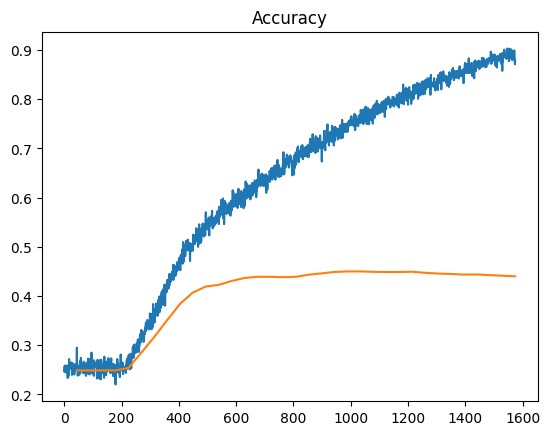

In [4]:
# TODO: Select Proper Hyperparameters, n_factors and n_epoch
n_factors = 200
n_epoch = 35

model = MatrixFactorizerWithBias(dataset.n_users, dataset.n_movies, n_factors)
trainer = Trainer(model, train_loader, valid_loader, device='cpu')
trainer.train_by_number_of_factors(n_factors)


### Select the model based on validation loss
- The training code saves model parameters for every epoch
- Based on your criteria, you can select the model by epoch
  - If you want to load the Epoch 4 version, run `model.load_state_dict(model_states[3])`

In [5]:
model.load_state_dict(torch.load('movielens_best.pt'))
# model.load_state_dict(trainer.model_states[3])
movie_embs = model.movie_embedding.weight.detach().cpu()
movie_bias = model.movie_bias.weight.detach().cpu()

## Problem 2: Analyze Bias of Movie Embedding: Why do we use Bias?
#### Explain why using bias helps to make a better recommendation system, based on the commonalities of movies with high bias and movies with low bias.

- Following code will show the title of movie by descending order of bias

In [ ]:
indices = torch.argsort(movie_bias.squeeze(), descending=True)
indices = indices.tolist()
pd.set_option('display.min_rows', 20) # you can set number of print rows by this line
pd.DataFrame({"title": list(movies['title'].iloc[indices]), "bias": movie_bias[indices].squeeze().tolist()})

## Problem 3: Similarity Search
#### Try to find the most similar movies and least similar movies for a given movie. Explain whether the searched result makes sense to you or not. In report, **explain at least three different queries of your choice.**
  - You have to attach the screen capture of the result
-----
- The following code will print out the movies based on their similarities to a selected movie
  - Similarities are calculated based on movie embeddings with cosine similarity
- You can search the id of movies from [assignment_3_list_of_movie_titles.csv](https://github.com/jdasam/mas1004/blob/2024/assignment_3_list_of_movie_titles.csv)

In [ ]:
def get_cosine_sim(emb, embs):
  with torch.no_grad():
    return torch.sum(emb * embs, dim=1) / (torch.sum(emb**2) * torch.sum(embs**2, dim=-1)) ** 0.5


In [ ]:
movie_embs = model.movie_embedding.weight.cpu()
sel_movie_id = 5682 # Select the desired movie ID from list_of_movie_titles.csv
sims = get_cosine_sim(movie_embs[sel_movie_id], movie_embs)
sims[sel_movie_id]=0
_, indices = torch.sort(sims, descending=True)
indices = indices.tolist()
print(f"Titles of selected movie_id is: {movies.iloc[sel_movie_id]['title']}")
pd.DataFrame({"title":list(movies['title'].iloc[indices]), "genre":list(movies['genres'].iloc[indices]), "similarity": sims[indices].tolist()})

## Problem 4: Embedding Visualization
#### Explain how your model could learn similarities between movies based only on the user's ratings. Navigate through the visualization and discover interesting informations from the embeddings.
  - For examples,
    - Which movies are making a cluster?
      - Are the movies in a cluster looks similar to you?
    - Which movies are located far away?
----
- You can use both 2D plot and 3D plot, or just select one to work with based on your preference
  - I recommend you to use 2D plot for discovering local cluster, and 3D plot for global view

- **You have to attach the screen capture of each cluster**
- The code below will make UMAP transformation of the given trained movie embeddings
  - Regardless of what factor you selected for the matrix factorization, UMAP can reduce the dimension of embedding to 2D or 3D
  - UMAP is one of machine learning algorithms for reducing data dimension, and it is a very good tool for making data visualization
  - During the dimension reduction, UMAP tries to the preserve local neighbor distance and also the global distance
  - Movies with similar embeddings will be located closely to each other in the UMAP embeddings
  - For the detailed explanation about what is UMAP, please refer this [YouTube video](https://youtu.be/6BPl81wGGP8)


### 0: Install and Import Library, Setup pre-defined functions

In [ ]:
!pip install -q umap-learn
!pip install -Uq plotly

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

def get_umap_embedding(embedding, n_reduced_dimension=2, n_neighbors=15):
  reducer = umap.UMAP(n_components=n_reduced_dimension, n_neighbors=n_neighbors)
  umap_emb = reducer.fit_transform(embedding)
  return umap_emb

def make_scatter3d(emb, label):
  trace = go.Scatter3d(
    x=emb[:,0],
    y=emb[:,1],
    z=emb[:,2],
    mode='markers',
    marker={
        'size': 2,
        'opacity': 0.5,
    },
    text = label,
  )
  return trace

def make_3d_plot_with_pyplot(embs, labels, highlighted_titles):
  highlighted_indices = [labels.index(title) if title in labels else 0 for title in highlighted_titles]
  layout = go.Layout(
      margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
      scene=dict(
          annotations = [dict(x=embs[i,0], y=embs[i,1], z=embs[i,2],text=labels[i]) for i in highlighted_indices ]
      )
  )
  data = make_scatter3d(embs,labels)
  plot_figure = go.Figure(data=data, layout=layout)
  plot_figure.update_traces(textposition='top center')
  plot_figure.show(renderer='colab')



### 4-1 Make Embeddings
- `n_neighbors` is a hyperparameter of UMAP. If you use larger n_neighbors, UMAP will consider more neighbors for each item

In [ ]:
movie_embs_np = movie_embs.detach().numpy()

embs_2d = get_umap_embedding(movie_embs_np, n_reduced_dimension=2, n_neighbors=15)
embs_3d = get_umap_embedding(movie_embs_np, n_reduced_dimension=3, n_neighbors=15)

- Following code will make simple static PLT plot

In [ ]:
plt.scatter(embs_2d[:,0], embs_2d[:,1])

- Following code will make interactive 3D plot of UMAP embedding

In [ ]:
make_3d_plot_with_pyplot(embs_3d, list(movies['title']), highlighted_titles=[])

#### Filter Movies based on Movie Ratings
- Are you tired of looking through the movie title of that you've never heard of?
- You can filter the embeddings based on movie ratings, so that you can select embeddings with number of ratings
  - Frequently rated movies can be regarded as famous movies
  - You can select the number of plots by changing `k=n_movies`
  - e.g. `k=100` to select only top 100 movies in number of ratings

In [ ]:
def get_mean_movie_ratings(ratings, movie_ids):
  scores = [ratings[ratings['movieId']==id]['rating'].mean() if len(ratings[ratings['movieId']==id])>0 else 0  for id in movie_ids]
  return scores

def get_number_movie_ratings(ratings, movie_ids):
  scores = [(ratings['movieId']==id).sum()  for id in movie_ids]
  return scores
# movie_ratings_in_order_of_title = get_mean_movie_ratings(ratings, list(dls.classes['title']))
num_movie_ratings_in_order_of_title = get_number_movie_ratings(ratings, list(movies['movieId']))

In [ ]:
k = 500
# k = n_movies # select desired number of movies
indices_of_top_k_movies =  np.asarray(num_movie_ratings_in_order_of_title).argsort()[::-1][:k]
movie_embs_filtered = movie_embs_np[indices_of_top_k_movies]

filtered_2d_embs = get_umap_embedding(movie_embs_filtered, n_reduced_dimension=2, n_neighbors=15)
filtered_3d_embs = get_umap_embedding(movie_embs_filtered, n_reduced_dimension=3, n_neighbors=15)
filtered_titles = movies.iloc[indices_of_top_k_movies]['title']
filtered_titles.tolist()

#### 2D plot
- Navigate the 2D UMAP plot to find interesting clusters of movies
- You can zoom and navigate through the interface on top right of the plotly figure, as below

![image.png](https://github.com/jdasam/mas1004/blob/2023/figs/assign_3_figure1.jpg?raw=true)

In [ ]:
import plotly.express as px

fig = px.scatter(x=filtered_2d_embs[:,0], y=filtered_2d_embs[:,1], text=list(filtered_titles))
fig.show(renderer="colab")


#### 3D Plot
- You can rotate the camera with left click drag
- You can pan the camera with right click drag
- You can add 3D title annotations by add titles in `highlighted_movie_titles`
  - e.g. `highlighted_movie_titles = ["Titanic (1997)", "Back to the Future (1985)"]`
  - You have to exactly match the title name
    - including year, and upper cases


In [ ]:
highlighted_movie_titles = ["Titanic (1997)", "Back to the Future (1985)", "Spider-Man (2002)", "Batman Begins (2005)"]
make_3d_plot_with_pyplot(filtered_3d_embs,list(filtered_titles), highlighted_titles=highlighted_movie_titles)

## Problem 5: Interpreting Dimension
#### The trained embedding space has several dimensions. Can you explain what kind of characteristics does each dimension represents?
----
- For a selcted dimension, try to figure out what is the commonalities between movies with high value in that dimension, and between movies with low value in that dimension
  - Give your explanation or hypothesis that can explain one of the dimensions
    - e.g. "This dimension seems that it represents 'Casting-Top-Male-Star', because movies with famous male actor had high value"
    - e.g. "This dimension seems that it represents 'Horror film', because horror movies got the high values and movies for children had low values"
  - There is no answer to this question. The trained result can be different based on the number of factors and random seed for the random initialization
    - You don't have to explain all the dimension.
    - Your hypothesis doesn't need to be perfect, that can explains entire tendency
- **You HAVE TO attach the screen capture of top 10 and bottom 10 movies of the selected dimension on the report**
- **In the report, include examples of two different dimensions**
- You can set the print options with `pd.set_option('display.min_rows', 20)`

In [ ]:
selected_dim_idx = 0
movie_embs_tensor = torch.tensor(movie_embs)
_, indices = torch.sort(movie_embs_tensor[:,selected_dim_idx], descending=True)
indices = indices.tolist()
pd.DataFrame({"title": list(movies.iloc[indices]['title']), "Genres": list(movies.iloc[indices]['genres']),  "Value": movie_embs[indices, selected_dim_idx].tolist()})

## Problem 6: Train Your Own Personalized Embedding
- In this problem, you will create your own user embedding based on your personal movie preferences
- **Rate at least 10 movies** from the `list_of_movie_titles.csv` file
  - Choose movies that you have actually watched
  - Give ratings between 0.5 and 5.0 (in 0.5 increments, following the MovieLens rating system)
- Train your own user embedding vector using the pretrained movie embeddings
- Analyze the recommendations generated for you based on your ratings
- **In your report, include:**
  1. The list of movies you rated with your ratings
  2. Screen capture showing your top 10 recommended movies
  3. Analysis of whether the recommendations make sense based on your preferences
  4. Discussion of what you learned about how recommendation systems understand user preferences


### Step 1: Input Your Movie Ratings
- Browse through `list_of_movie_titles.csv` to find movies you've watched
- Add your ratings to the dictionary below
- The key should be the **index** from the CSV file (first column)
- The value should be your rating (0.5 to 5.0)


In [ ]:
# TODO: Add your movie ratings here
# Format: {movie_index: rating}
# Example: {0: 4.5, 45: 5.0, 150: 3.0, ...}
my_ratings = {
  0: 4.0,    # Toy Story (1995)
  43: 5.0,   # Seven (a.k.a. Se7en) (1995)
}

# Validate your ratings
assert len(my_ratings) >= 10, "Please rate at least 10 movies!"
assert all(0.5 <= rating <= 5.0 for rating in my_ratings.values()), "Ratings must be between 0.5 and 5.0"
assert all(rating % 0.5 == 0 for rating in my_ratings.values()), "Ratings must be in 0.5 increments"

print(f"You have rated {len(my_ratings)} movies:")
for movie_idx, rating in my_ratings.items():
    print(f"  {movies.iloc[movie_idx]['title']}: {rating}")


### Step 2: Train Your User Embedding
- We will train your personal user embedding by minimizing the difference between:
  - Your actual ratings
  - The predicted ratings from the dot product of your user embedding and the pretrained movie embeddings
- This is similar to how the model learned user embeddings during training
- We keep the movie embeddings frozen (pretrained) and only optimize your user embedding


In [ ]:
# Prepare your ratings data
movie_indices = torch.tensor(list(my_ratings.keys()), dtype=torch.long)
my_ratings_tensor = torch.tensor(list(my_ratings.values()), dtype=torch.float32)

# Initialize your user embedding randomly
my_user_embedding = nn.Parameter(torch.randn(n_factors) / (n_factors ** 0.5))
my_user_bias = nn.Parameter(torch.zeros(1))

# Get the pretrained movie embeddings (frozen - we don't update these)
pretrained_movie_embs = model.movie_embedding.weight.detach()
pretrained_movie_bias = model.movie_bias.weight.detach()

# Setup optimizer to only train YOUR embedding
optimizer = torch.optim.Adam([my_user_embedding, my_user_bias], lr=0.01)
criterion = nn.MSELoss()

# Training loop
num_iterations = 500
losses = []

for iteration in range(num_iterations):
  optimizer.zero_grad()

  # Get embeddings for the movies you rated
  rated_movie_embs = pretrained_movie_embs[movie_indices]
  rated_movie_bias = pretrained_movie_bias[movie_indices]

  # Calculate predicted ratings
  # dot product of your embedding with each movie embedding
  dot_products = torch.sum(my_user_embedding * rated_movie_embs, dim=1)
  predictions = dot_products + my_user_bias + rated_movie_bias.squeeze()
  predictions = model.scaled_sigmoid(predictions)

  # Calculate loss
  loss = criterion(predictions, my_ratings_tensor)

  # Backpropagate and update your embedding
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

  if (iteration + 1) % 100 == 0:
    print(f"Iteration {iteration+1}/{num_iterations}, Loss: {loss.item():.4f}")

# Plot the training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.title('Training Your User Embedding')
plt.grid(True)
plt.show()

print("\nTraining complete! Your personalized embedding has been learned.")


### Step 3: Verify Your Learned Embedding
- Let's check how well your embedding fits your actual ratings
- The predicted ratings should be close to your original ratings


In [ ]:
# Check how well the model fits your ratings
with torch.inference_mode():
  rated_movie_embs = pretrained_movie_embs[movie_indices]
  rated_movie_bias = pretrained_movie_bias[movie_indices]

  dot_products = torch.sum(my_user_embedding * rated_movie_embs, dim=1)
  predictions = dot_products + my_user_bias + rated_movie_bias.squeeze()
  predictions = model.scaled_sigmoid(predictions)

# Create a comparison dataframe
comparison_df = pd.DataFrame({
  'Movie': [movies.iloc[idx]['title'] for idx in my_ratings.keys()],
  'Your Rating': list(my_ratings.values()),
  'Predicted Rating': predictions.numpy().round(2),
  'Difference': (predictions.numpy() - my_ratings_tensor.numpy()).round(2)
})

print("How well does your embedding fit your ratings?")
print(comparison_df.to_string(index=False))
print(f"\nMean Absolute Error: {torch.abs(predictions - my_ratings_tensor).mean().item():.3f}")


### Step 4: Get Your Personalized Movie Recommendations
- Now use your trained embedding to predict ratings for ALL movies
- Movies you haven't rated will get predicted ratings based on your learned preferences
- This shows which movies the recommendation system thinks you would enjoy!


In [ ]:
# Predict ratings for ALL movies
with torch.inference_mode():
  # Calculate dot product with all movie embeddings
  all_dot_products = torch.sum(my_user_embedding * pretrained_movie_embs, dim=1)
  all_predictions = all_dot_products + my_user_bias + pretrained_movie_bias.squeeze()
  all_predictions = model.scaled_sigmoid(all_predictions)

# Get indices of movies sorted by predicted rating
sorted_indices = torch.argsort(all_predictions, descending=True)

# Filter out movies you already rated
unrated_movie_indices = [idx.item() for idx in sorted_indices if idx.item() not in my_ratings]

# Show top recommended movies
print("=" * 80)
print("YOUR TOP 20 RECOMMENDED MOVIES (that you haven't rated yet)")
print("=" * 80)

recommendations = []
for i, movie_idx in enumerate(unrated_movie_indices[:20]):
  title = movies.iloc[movie_idx]['title']
  genre = movies.iloc[movie_idx]['genres']
  predicted_rating = all_predictions[movie_idx].item()
  recommendations.append({
      'Rank': i + 1,
      'Movie': title,
      'Genres': genre,
      'Predicted Rating': round(predicted_rating, 2)
  })

recommendations_df = pd.DataFrame(recommendations)
print(recommendations_df.to_string(index=False))


### Step 5: Analyze Your Embedding in the Movie Space
- Find which existing users in the dataset have similar preferences to you
- This helps understand what "type" of movie watcher you are according to the model


In [ ]:
# Find similar users to you
all_user_embeddings = model.user_embedding.weight.detach().cpu()

# Calculate cosine similarity with all users
with torch.inference_mode():
  similarities = get_cosine_sim(my_user_embedding.detach(), all_user_embeddings)

# Get top 5 most similar users
top_similar_indices = torch.argsort(similarities, descending=True)[:5]

print("=" * 80)
print("Top 5 most similar users to you in the dataset:")
print("=" * 80)

for i, user_idx in enumerate(top_similar_indices):
  user_id = dataset.user_ids[user_idx.item()]
  similarity = similarities[user_idx].item()

  # Get all ratings for this user
  user_ratings_df = ratings[ratings['userId'] == user_id].copy()

  # Merge with movie titles
  user_ratings_df = user_ratings_df.merge(movies[['movieId', 'title', 'genres']], on='movieId', how='left')

  # Sort by rating
  user_ratings_sorted = user_ratings_df.sort_values('rating', ascending=False)

  print(f"\n{'='*80}")
  print(f"User {user_id} (Similarity: {similarity:.3f})")
  print(f"{'='*80}")

  # Top 5 ratings
  print(f"\nTop 5 Highest Ratings:")
  top_5 = user_ratings_sorted.head(5)[['title', 'genres', 'rating']]
  print(top_5.to_string(index=False))

  # Bottom 5 ratings
  print(f"\nTop 5 Lowest Ratings:")
  bottom_5 = user_ratings_sorted.tail(5)[['title', 'genres', 'rating']]
  print(bottom_5.to_string(index=False))
  print()


### Step 6: Explore Movies Most Aligned with Your Preferences
- Which movies best represent your taste?
- These are movies whose embeddings are most similar to your user embedding
- Even if you haven't rated them, they define "your kind of movie"


In [ ]:
# Find movies most aligned with your preferences (highest cosine similarity)
with torch.no_grad():
    movie_similarities = get_cosine_sim(my_user_embedding.detach(), pretrained_movie_embs)

# Get top movies by similarity (not just predicted rating)
top_aligned_indices = torch.argsort(movie_similarities, descending=True)[:20]

print("=" * 80)
print("MOVIES MOST ALIGNED WITH YOUR TASTE (by embedding similarity)")
print("=" * 80)

aligned_movies = []
for i, movie_idx in enumerate(top_aligned_indices):
  title = movies.iloc[movie_idx.item()]['title']
  genre = movies.iloc[movie_idx.item()]['genres']
  similarity = movie_similarities[movie_idx].item()
  already_rated = "✓ (You rated this)" if movie_idx.item() in my_ratings else ""

  aligned_movies.append({
      'Rank': i + 1,
      'Movie': title,
      'Genres': genre,
      'Similarity': round(similarity, 3),
      'Rated': already_rated
  })

aligned_df = pd.DataFrame(aligned_movies)
print(aligned_df.to_string(index=False))

print("\n" + "=" * 80)
print("Notice: These movies define your 'type' in the embedding space!")
print("=" * 80)


### Questions for Your Report (Problem 6)

**Answer the following questions in your report:**

1. **Your Ratings**
  - List all movies you rated with your ratings

2. **Recommendation Quality**
  - Show a screen capture of your top 10-20 recommended movies
  - Analyze whether these recommendations make sense based on your actual preferences
  - Are there any surprising recommendations? Why might the system suggest them?

3. **Understanding Your Embedding**
  - Look at the "Movies Most Aligned with Your Taste" list
  - What patterns do you notice? (genres, time periods, styles, etc.)
  - Do these movies accurately represent your taste, even if you haven't watched all of them?

4. **Learning from the Experience**
   - What did you learn about how recommendation systems understand and model user preferences?
   - How does rating just 10 movies allow the system to predict your preferences for thousands of other movies?
   - What are the limitations of this approach based on your results?

**Remember to include:**
- Screen captures of your results
- Clear explanations of your observations
- Critical analysis of the recommendation system's performance for you personally
